## Хомутов Евгений Васильевич, МСКМ-191
# Вычислительная геномика

In [1]:
import pprint
import numpy as np
import matplotlib.pyplot as plt

Импортируем класс Croupier, который отвечает за генерацию данных и создадим экземпляр класса с заданными значениями вероятности для нечестного кубика, а так же вероятности перехода с честного кубика на нечестный и на себя самого, и вероятности перехода с нечестного кубика на себя и на честный. Проверим что получаем выпавшие знаечение кубика, а так же метку кубика.

В качестве начального распределения возьмем предельное распределение. Решая систему уравнений и нормировочное уравнение:
$$
0.95p_1+ 0.05p_2 = p_1
$$
$$
0.01p_1+ 0.9p_2 = p_2
$$
$$
p_1 + p_2 = 1 
$$
получаем, что искомые вероятности равны (2/3;1/3)

In [2]:
class Croupier():
    def __init__(self):
        print('Croupier init')
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': [0.95,0.05], # to F, to U
            'U': [0.1,0.9] # to F, to U
        }
        
        self.startProbability = [2/3,1/3]

        self.currentState = np.random.choice(self.states, p =self.startProbability)
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }


    def changeDice(self):
        self.currentState = np.random.choice(self.states,p=self.transitionsProbability[self.currentState])

    def roll(self):
        return np.random.choice(self.diceValues, p=self.diceValueProbability[self.currentState]), self.currentState

    def __call__(self):
        self.changeDice()
        return self.roll()

In [3]:
casino = Croupier()
for i in range(10):
    print(casino())

Croupier init
(6, 'U')
(6, 'U')
(4, 'U')
(4, 'U')
(1, 'U')
(6, 'U')
(6, 'U')
(4, 'U')
(6, 'U')
(4, 'U')


Сгенерируем датасеты размером 300, 1 000 и 10 000

In [4]:
dataset300 = []
dataset300Labels = []

casino = Croupier()

for i in range(300):
    data, label = casino()
    dataset300.append(data)
    dataset300Labels.append(label)

Croupier init


In [5]:
dataset1000 = []
dataset1000Labels = []

casino = Croupier()

for i in range(1000):
    data, label = casino()
    dataset1000.append(data)
    dataset1000Labels.append(label)

Croupier init


In [6]:
dataset10000 = []
dataset10000Labels = []

casino = Croupier()

for i in range(10000):
    data, label = casino()
    dataset10000.append(data)
    dataset10000Labels.append(label)

Croupier init


Ноль соответсвует честной кости, единица - нечестной.

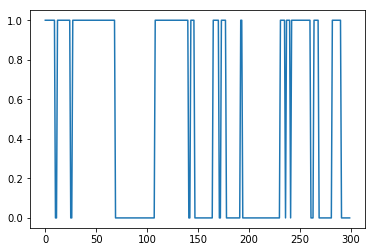

In [7]:
lab300 = [0 if l =='F' else 1 for l in dataset300Labels ]
plt.plot(lab300)

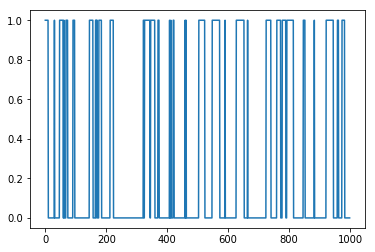

In [8]:
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
plt.plot(lab1000)

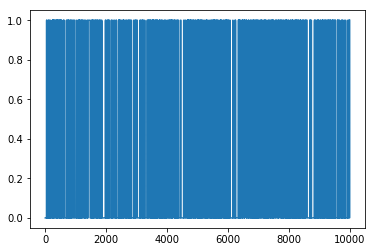

In [9]:
lab10000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
plt.plot(lab10000)

Посчитаем количество раз, когда использоволась какая кость для 10 000 раз

In [10]:
from collections import Counter
Counter(dataset10000Labels)

Counter({'F': 6666, 'U': 3334})

Все хорошо согласуется с предельным распределением, следовательно сплошная линия на графике для 10 000 ошибка изображения, но не моделирования

Определим базовый класс для алгоритмов, в котором будем хранить данные о нашей скрытой марковской цепи

In [11]:
class baseAlgo():
    def __init__(self, data):
        print("BaseAlgo init")
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6 for i in range(6)],
            'U': [.1,.1,.1,.1,.1,.5]
        }

## Алгоритм Витерби

Реализуем алгоритм Витерби

In [12]:
class algorithmViterbi(baseAlgo):
    def __init__(self, data):
        print('ViterbiAlgo init')
        baseAlgo.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability*np.max( self.v[index-1] * self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] * self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability*self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path

ViterbiAlgo init
BaseAlgo init
RESULT: 0.87
Probability: 7.326364602808543e-230


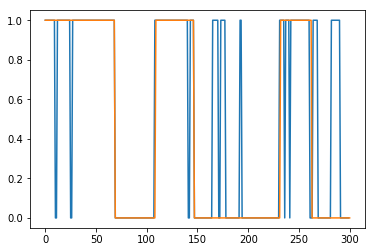

In [13]:
hackCasinoViterbi = algorithmViterbi(dataset300)
result = hackCasinoViterbi()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

ViterbiAlgo init
BaseAlgo init
RESULT: 0.729
Probability: 0.0


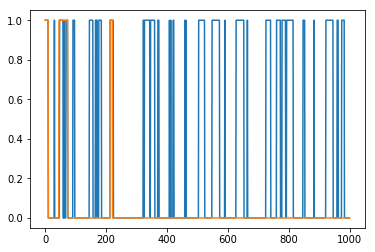

In [14]:
hackCasinoViterbi = algorithmViterbi(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

ViterbiAlgo init
BaseAlgo init
RESULT: 0.6723
Probability: 0.0


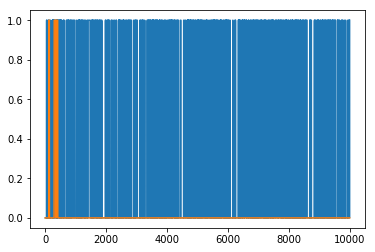

In [15]:
hackCasinoViterbi = algorithmViterbi(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbi.returnProbability()))

Из графиков икачетсва работы с 1000 и 10 000 экземпляров видно, что накапление машинной ошибки ведет к тому, что алгоритм уже не в состояние выдавать ненулевые значения. Чтобы избежать этого, перейдем в логарифмический масштаб

In [16]:
class baseAlgoLog():
    def __init__(self, data):
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.log([0.95,0.05]), # to F, to U
            'U': np.log([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': np.log(2/3),
            'U': np.log(1/3)
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': np.log([1/6 for i in range(6)]),
            'U': np.log([.1,.1,.1,.1,.1,.5])
        }

In [17]:
class algorithmViterbiLog(baseAlgoLog):
    def __init__(self, data):
        baseAlgoLog.__init__(self, data)
        
        self.v = []
        self.ptr = []
        
        self.path = None
        self.probability = None
        
        
    def step(self,index):
        self.v.append([])
        self.ptr.append([])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            probability = observedProbability + np.max( self.v[index-1] + self.transitionsProbability[state])
            ptr = 'F' if np.argmax(self.v[index-1] + self.transitionsProbability[state]) == 0 else 'U'
            self.v[-1].append(probability)
            self.ptr[-1].append(ptr)
            
    
    def initialization(self):
        self.v.append([])
        self.ptr.append(['F','U'])
        for state in self.states:
            observedProbability = self.diceValueProbability[state][self.data[0] - 1]
            probability = observedProbability + self.startProbability[state]
            self.v[0].append(probability)
        
        for i in range(1, self.L): 
            self.step(i)
        
        self.probability = np.e**max(self.v[-1])
        self.path = [ 'F' if np.argmax(self.v[-1]) == 0 else 'U' ]
        
        for i in range(self.L-1,0,-1):
            self.path.append(self.ptr[i][0 if self.path[-1] == 'F' else 1])
        
        self.path = self.path[::-1]
    
    def returnProbability(self):
        if self.probability != None: return self.probability
    
    def __call__(self):
        if self.path == None: self.initialization()
        return self.path
        

RESULT: 0.87
Probability: 7.326364602803177e-230


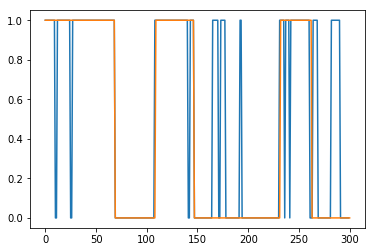

In [18]:
hackCasinoViterbiLog = algorithmViterbiLog(dataset300)
result = hackCasinoViterbiLog()
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab300)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab300,res)])/len(lab300)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.823
Probability: 7.326364602803177e-230


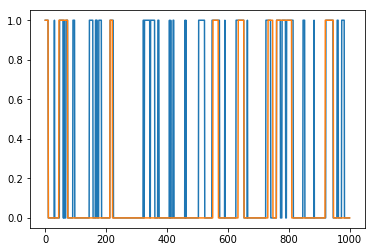

In [19]:
hackCasinoViterbi = algorithmViterbiLog(dataset1000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset1000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab1000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab1000,res)])/len(lab1000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

RESULT: 0.8039
Probability: 7.326364602803177e-230


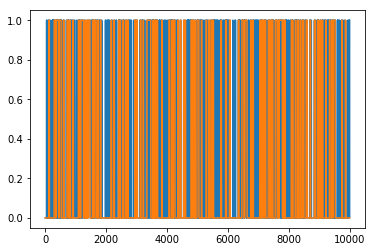

In [20]:
hackCasinoViterbi = algorithmViterbiLog(dataset10000)
result = hackCasinoViterbi()
lab1000 = [0 if l =='F' else 1 for l in dataset10000Labels ]
res = [0 if l =='F' else 1 for l in result]
res.append(0)
plt.plot(lab10000)
plt.plot(res)
print('RESULT: {}'.format( sum([ l == r for l,r in zip(lab10000,res)])/len(lab10000)))
print('Probability: {}'.format(hackCasinoViterbiLog.returnProbability()))

Использование логарифмического масштаба улучшило работы алгоритма, что видно как гарфически так и численно, в сравнение с правильными лейблами для костей.

## Алгорит прямого и обратного хода, апостериорное дешифрование

In [21]:
class forwardAlgorithm(baseAlgo):
    def __init__(self, data):
        #baseAlgo.__init__(self, data)
        super().__init__(data)
        print('Forward init')
        
        self.f = []
        self.pathProbability = None
    
    def stepForward(self, index):
        self.f.append([])
        previuosState = self.f[-2]
        for i,state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[index] - 1]
            
            """
            observedProbability: вероятсность наблюдения при текущем состояние
            transitionProbability: вероятность перехода с кубика на кубик
            """
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[-1].append(probability)
    
    def __call__(self):
        if self.pathProbability == None: self.initialization()
        return self.pathProbability
    
    def initialization(self):
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])

In [22]:
class backwardAlgorithm(baseAlgo):
    def __init__(self, data):
        #baseAlgo.__init__(self, data)
        super().__init__(data)
        print('Backward init')
        
        self.b = []
        self.pathProbabilityB = None
    
    def stepBackward(self, index):
        self.b.append([])
        observedProbability =  np.array([val[self.data[index]-1] for val in self.diceValueProbability.values()])
        nextState = self.b[-2]
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[-1].append(probability)
    
    def __call__(self):
        if self.pathProbabilityB == None: self.initialization()
        return self.pathProbabilityB
    
    def initialization(self):
        self.b.append([1 for state in self.states])
        #Recursion
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        # Finish # перевернуть b
        self.b = self.b[::-1]
        self.pathProbabilityB = sum(self.b[0])

In [23]:
backwardHack = backwardAlgorithm(dataset300)
b=backwardHack()
forwardHack = forwardAlgorithm(dataset300)
f=forwardHack()

print('FORWARD: {}\nBACKWARD: {}\n'.format(f,b))

BaseAlgo init
Backward init
BaseAlgo init
Forward init
FORWARD: 9.433403237665489e-221
BACKWARD: 1.71354416464525e-219



Проверим, что все считается верно: перемножим f и b в каждом столбце

In [24]:
pprint.pprint([sum(f*np.array(b)) for f, b in zip(forwardHack.f, backwardHack.b)])

[9.433403237665595e-221,
 9.433403237665595e-221,
 9.433403237665595e-221,
 9.433403237665595e-221,
 9.433403237665593e-221,
 9.433403237665591e-221,
 9.433403237665591e-221,
 9.433403237665591e-221,
 9.433403237665593e-221,
 9.433403237665591e-221,
 9.433403237665591e-221,
 9.433403237665591e-221,
 9.433403237665591e-221,
 9.433403237665591e-221,
 9.433403237665591e-221,
 9.43340323766559e-221,
 9.43340323766559e-221,
 9.43340323766559e-221,
 9.43340323766559e-221,
 9.433403237665591e-221,
 9.433403237665587e-221,
 9.433403237665587e-221,
 9.433403237665587e-221,
 9.433403237665587e-221,
 9.433403237665587e-221,
 9.433403237665587e-221,
 9.433403237665585e-221,
 9.433403237665585e-221,
 9.433403237665583e-221,
 9.433403237665583e-221,
 9.433403237665583e-221,
 9.433403237665583e-221,
 9.433403237665581e-221,
 9.433403237665583e-221,
 9.433403237665583e-221,
 9.433403237665581e-221,
 9.433403237665581e-221,
 9.433403237665581e-221,
 9.433403237665583e-221,
 9.43340323766558e-221,
 9.43

Так как на каждом шаге у нас выдается одна и таже величина, то прямой и обратный ход работfют корректно

In [25]:
class PosteriorDecoding(forwardAlgorithm, backwardAlgorithm):
    def __init__(self, data):
        #baseAlgo.__init__(self, data)
        #forwardAlgorithm.__init__(self, data)
        #backwardAlgorithm.__init__(self, data)
        super().__init__(data)
        # For decoding
        self.conditionalProbability = None
            
    def __call__(self):
        if self.conditionalProbability == None: self.initialization()
        return self.conditionalProbability
    
    def initialization(self):
        ### Forward part ###
        self.pathProbability = 0.0
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        
        self.b.append([1 for state in self.states])
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        for i in range(self.L):
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability
            self.conditionalProbability.append(conProb)

BaseAlgo init
Backward init
Forward init


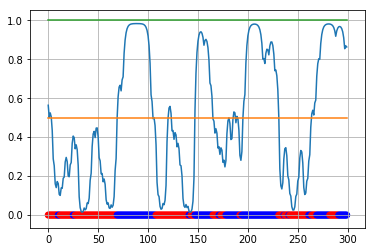

In [26]:
PosteriorHack = PosteriorDecoding(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

BaseAlgo init
Backward init
Forward init


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


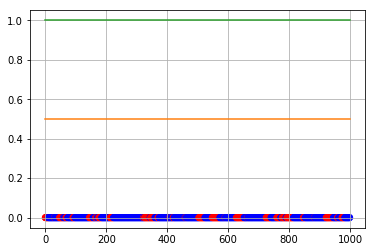

In [27]:
PosteriorHack = PosteriorDecoding(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

BaseAlgo init
Backward init
Forward init


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


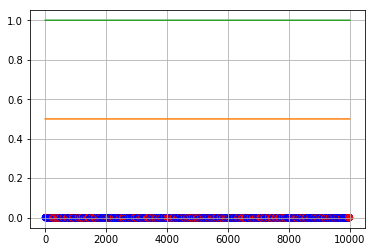

In [28]:
PosteriorHack = PosteriorDecoding(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

Из-за потери машиной точности, графики на последовательностях 1000 и 10 000 построить не получилось. Чтобы исправить эту проблему применим масштабирование для алгоритма декодирования

In [29]:
class PosteriorDecodingScaled(PosteriorDecoding):
    def __init__(self, data):
        PosteriorDecoding.__init__(self,data)
        # For scaling
        self.scaledConstF = []
        self.scaledConstB = []
        
    def stepForward(self, index):
        super().stepForward(index)
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
        
    def stepBackward(self, index):
        super().stepBackward(index)
        
        self.scaledConstB.append(max(self.b[-1]))
        self.b[-1] = self.b[-1]/self.scaledConstB[-1]        
        
    def initialization(self): # Тоже следует красиво переписать
        ### Forward part ###
        # Init
        self.f.append([self.startProbability[state] for state in self.states] * 
                      np.array([self.diceValueProbability[state][self.data[0] - 1] for state in self.states]))
        
        self.scaledConstF.append(max(self.f[-1]))
        self.f[-1] = self.f[-1]/self.scaledConstF[-1]
        # Recursion
        for i in range(1,self.L):
            self.stepForward(i)
        self.pathProbability = sum(self.f[-1])
        ### ____________ ###
        
        ### Backward and decoding ###
        self.conditionalProbability = []
        
        self.b.append([1 for state in self.states])
        self.scaledConstB.append(1)
        for i in range(self.L-1,0,-1):
            self.stepBackward(i)
            
        self.b = self.b[::-1]
        self.scaledConstB = self.scaledConstB[::-1]
        for i in range(self.L):
            # трюк чтобы не терять точность
            ###
            coeff = 1
            for backCoeff, forwardCoeff in zip(self.scaledConstB[i:],self.scaledConstF[i+1:]):
                coeff *= backCoeff/forwardCoeff
                
            conProb = self.f[i][0]*self.b[i][0] / self.pathProbability * coeff
            self.conditionalProbability.append(conProb)

BaseAlgo init
Backward init
Forward init


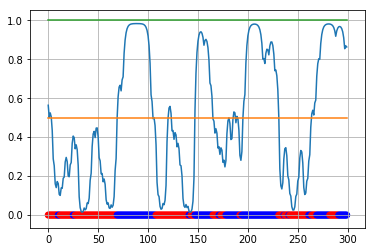

In [30]:
PosteriorHack = PosteriorDecodingScaled(dataset300)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset300Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)

ax.plot([.5 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

BaseAlgo init
Backward init
Forward init


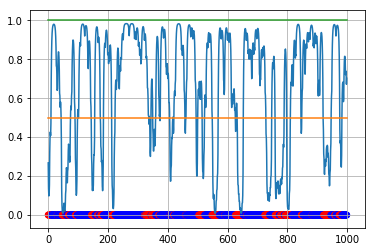

In [31]:
PosteriorHack = PosteriorDecodingScaled(dataset1000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset1000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

BaseAlgo init
Backward init
Forward init


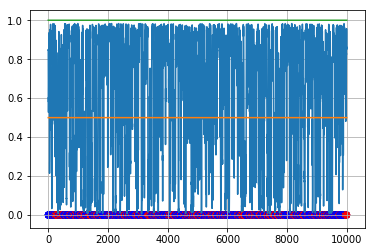

In [32]:
PosteriorHack = PosteriorDecodingScaled(dataset10000)
conditionsProbs = PosteriorHack()
fig,ax = plt.subplots()
ax.grid(True, which='both')
ax.axis('on')
ax.plot(conditionsProbs)
labelColor = ['b' if l == 'F' else 'r' for l in dataset10000Labels]
ax.scatter(range(len(conditionsProbs)),[0 for i in conditionsProbs],color=labelColor)
ax.plot([.50 for i in conditionsProbs])
ax.plot([1 for i in conditionsProbs])

## Алгоритм Баума-Велша

Реализуем класс с параметрами, которые не совпадают с параметрами используемой марковской цепи.

In [34]:
class parametrs:
    def __init__(self, data):
        
        self.isFitted = False
        
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.95,0.05]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [1/6,1/6,1/6,1/6,1/6,1/6],
            'U': [1/10,1/10,1/10,1/10,1/10,1/2]
        }

In [50]:
class parametrs:
    def __init__(self, data):
        
        self.isFitted = False
        
        self.data = data
        self.L = len(data)
        
        self.states = ['F','U'] # F for Fair state, U for Unfair state
        self.transitionsProbability = {
            'F': np.array([0.8,0.2]), # to F, to U
            'U': np.array([0.1,0.9]) # to F, to U
        }
        
        self.startProbability = {
            'F': 2/3,
            'U': 1/3
        }
        
        self.diceValues = [1,2,3,4,5,6]
        self.diceValueProbability = {
            'F': [2/12,2/12,2/12,3/12,2/12,1/12],
            'U': [2/20,4/20,1/20,3/20,2/20,8/20]
        }

In [59]:
class BaumWelchTrainig(parametrs, PosteriorDecoding):
    def __init__(self, data):
        
        super().__init__(data)
        
        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            self.f = []
            self.b = []
            self.pathProbability = .0
            self.initialization()
            # Change paramets
            self.changeParametrs()
            
            currentLog = self.logLikelihood()
            print("LOG: {}".format(currentLog))
            
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
        else:
            print('Stop: max iterations')
    
    def logLikelihood(self):
        return np.log(self.pathProbability)
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                sum_step = [
                    self.f[i][fromI] * self.b[i+1][newI] * 
                    self.diceValueProbability[newState][self.data[i+1] - 1] 
                    for i in range(self.L-1)
                ]
                probability = sum(sum_step) * self.transitionsProbability[fromState][newI]#/self.pathProbability
                A[fromState][newState] = probability
        # Add B
        B = {}
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for i,value in enumerate(self.data):
                B[state][value - 1] =+ self.f[i][index] * self.b[i][index]
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
                
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)
        
# Без фиксации 
trainig = BaumWelchTrainig(dataset300)
trainig()

LOG: -517.8419711362919
LOG: -534.2693481762228
LOG: -536.2865500547379
LOG: -536.9966471983307
LOG: -539.0151245500069
LOG: -541.2584581842523
LOG: -544.2637412502152
LOG: -545.1245792168296
LOG: -542.2456534270603
LOG: -539.0361603129195
LOG: -537.3583182521209
LOG: -536.6945032328451
LOG: -536.4632697294463
LOG: -536.3861878569168
Log doesnot change: stop in 13 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([0.59177165, 0.40822835]), 'U': "
 'array([0.46981661, 0.53018339])}')
("diceValueProbability: {'F': [0.3129839960550045, 0.3129670694098222, "
 '0.29453775450504427, 0.0009963520608497866, 1.9273268605317846e-07, '
 "0.07851463523659329], 'U': [9.265300278819077e-10, 1.928167424810493e-05, "
 '0.02101168551249892, 0.355377867608472, 0.3565125695229003, '
 '0.26707859475535056]}')


In [60]:
class BaumWelchTrainig(parametrs, PosteriorDecoding):
    def __init__(self, data):
        
        super().__init__(data)
        
        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            self.f = []
            self.b = []
            self.pathProbability = .0
            self.initialization()
            # Change paramets
            self.changeParametrs()
            
            currentLog = self.logLikelihood()
            print("LOG: {}".format(currentLog))
            
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
        else:
            print('Stop: max iterations')
    
    def logLikelihood(self):
        return np.log(self.pathProbability)
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                sum_step = [
                    self.f[i][fromI] * self.b[i+1][newI] * 
                    self.diceValueProbability[newState][self.data[i+1] - 1] 
                    for i in range(self.L-1)
                ]
                probability = sum(sum_step) * self.transitionsProbability[fromState][newI]#/self.pathProbability
                A[fromState][newState] = probability
        # Add B
        B = {}
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for i,value in enumerate(self.data):
                B[state][value - 1] =+ self.f[i][index] * self.b[i][index]
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        #self.transitionsProbability = {
        #    'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
        #    'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        #}
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
                
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

# С фиксированными transitionsProbability
        
trainig = BaumWelchTrainig(dataset300)
trainig()

LOG: -517.8419711362919
LOG: -534.415260413031
LOG: -536.3871444434196
LOG: -537.7465037261874
LOG: -540.1220363199653
LOG: -544.3121752894928
LOG: -549.9365315130508
LOG: -555.9263246859064
LOG: -562.3010638923363
LOG: -568.8509750238082
LOG: -572.4457775202576
LOG: -573.1216403009314
LOG: -573.2092009764121
Log doesnot change: stop in 12 iteration
'FITTED'
'Parametrs'
"TransitionsProbability: {'F': array([0.8, 0.2]), 'U': array([0.1, 0.9])}"
("diceValueProbability: {'F': [0.9998560681677676, 3.873142264591978e-05, "
 '1.1272755176695537e-05, 9.34599672254389e-05, 8.026707683215597e-12, '
 "4.6767915753688916e-07], 'U': [1.6403272798347313e-09, 0.19999801031711645, "
 '0.2000035029992424, 0.1999870627174586, 0.2000057579381191, '
 '0.20000566438773615]}')


In [61]:
class BaumWelchTrainig(parametrs, PosteriorDecoding):
    def __init__(self, data):
        
        super().__init__(data)
        
        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            self.f = []
            self.b = []
            self.pathProbability = .0
            self.initialization()
            # Change paramets
            self.changeParametrs()
            
            currentLog = self.logLikelihood()
            print("LOG: {}".format(currentLog))
            
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
        else:
            print('Stop: max iterations')
    
    def logLikelihood(self):
        return np.log(self.pathProbability)
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                sum_step = [
                    self.f[i][fromI] * self.b[i+1][newI] * 
                    self.diceValueProbability[newState][self.data[i+1] - 1] 
                    for i in range(self.L-1)
                ]
                probability = sum(sum_step) * self.transitionsProbability[fromState][newI]#/self.pathProbability
                A[fromState][newState] = probability
        # Add B
        B = {}
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for i,value in enumerate(self.data):
                B[state][value - 1] =+ self.f[i][index] * self.b[i][index]
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        #self.diceValueProbability = {
        #    'F': [value/fair for value in B['F']],
        #    'U': [value/unfair for value in B['U']]
        #}
                
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

# С фиксированными diceValueProbability
        
trainig = BaumWelchTrainig(dataset300)
trainig()

LOG: -517.8419711362919
LOG: -517.6787770316014
LOG: -517.5143345832246
LOG: -517.3504965929739
LOG: -517.1896448186171
LOG: -517.0343896070598
LOG: -516.8873843242153
LOG: -516.7511408915354
LOG: -516.6278333912202
LOG: -516.5191041631603
LOG: -516.4259001179893
Log doesnot change: stop in 10 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([0.89927012, 0.10072988]), 'U': "
 'array([0.04590009, 0.95409991])}')
("diceValueProbability: {'F': [0.16666666666666666, 0.16666666666666666, "
 "0.16666666666666666, 0.25, 0.16666666666666666, 0.08333333333333333], 'U': "
 '[0.1, 0.2, 0.05, 0.15, 0.1, 0.4]}')


( Ошибка в diceValueProbability, так как при фиксированных transitionsProbability логарифм увеличвается)

После тренировке на 300 бросках, алгоритм смог равномерно раскидать выпадающие значения на кубиках, а так же смог уловить общую тенденцию в переходах между кубиками (проще остаться с этим же кубиком, чем перейти), и в общих чертах смог выделить нечестный кубик.

In [37]:
trainig = BaumWelchTrainig(dataset1000)
trainig()

LOG: -inf
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
LOG: nan
Stop: max iterations
'FITTED'
'Parametrs'
"TransitionsProbability: {'F': array([nan, nan]), 'U': array([nan, nan])}"
("diceValueProbability: {'F': [nan, nan, nan, 

На 1000 бросках происходит накопление ошибки, что ведет к переполнению переменных.
Сделаем нормированную версию алгоритма

In [38]:
def multiply(array):
    result = 1
    for i in array:
        result *= i
    return result

In [39]:
class BaumWelchTrainigScaled(parametrs, PosteriorDecodingScaled):
    def __init__(self, data):

        PosteriorDecoding.__init__(self, data)
        parametrs.__init__(self, data)

        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 0
        for step in range(self.iterationNumber):
            self.scaledConstF = []
            self.scaledConstB = []
            
            self.f = []
            self.b = []
            
            self.initialization()
            currentLog = self.logLikelihood()
            
            # Change paramets
            print(currentLog)
            
            if prLog > currentLog:
                print('Log decreased: {} iteration'.format(step))
            #    break
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
            self.changeParametrs()
            
        else:
            print('Stop: max iterations')
    
    
    def logLikelihood(self):
        return np.log(self.pathProbability*multiply(self.scaledConstF))

    def coeff(self,currentI):
        # трюк чтобы не терять точность
        ###
        coeff_num = 1
        for backCoeff, forwardCoeff in zip(self.scaledConstB[currentI+1:],self.scaledConstF[currentI:]):
            coeff_num *= backCoeff/forwardCoeff
        return coeff_num
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                sum_step = [
                    self.f[i][fromI] * self.b[i+1][newI] * 
                    self.diceValueProbability[newState][self.data[i+1] - 1] * self.coeff(i)
                    for i in range(self.L-1)
                ]
                probability = sum(sum_step) * self.transitionsProbability[fromState][newI]/self.pathProbability
                A[fromState][newState] = probability
        # Add B
        
        
        B = {}
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for i,value in enumerate(self.data):
                B[state][value - 1] =+ self.f[i][index] * self.b[i][index] * multiply(self.scaledConstF[:i + 1]) * multiply(self.scaledConstB[i:])
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
        
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

In [40]:
trainig = BaumWelchTrainigScaled(dataset300)
trainig()

BaseAlgo init
Backward init
Forward init
-506.62704862537726
Log decreased: 0 iteration
-542.7589082042418
Log decreased: 1 iteration
-533.3617637668184
-532.6305552727736
-535.6886408726838
Log decreased: 4 iteration
-537.4046139738906
Log decreased: 5 iteration
-537.7609993137664
Log decreased: 6 iteration
-537.8581655739412
Log decreased: 7 iteration
Log doesnot change: stop in 7 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([9.99440584e-01, 5.59416291e-04]), 'U': "
 'array([0.94178534, 0.05821466])}')
("diceValueProbability: {'F': [0.1668534847051443, 0.16685336695105907, "
 '0.1668522345970403, 0.1666847942294742, 0.16591925477954395, '
 "0.16683686473773815], 'U': [1.0836823950327798e-05, 0.00011588238028969114, "
 '0.001126027868412226, 0.15049550863855848, 0.8334146386387831, '
 '0.014837105650006188]}')


In [41]:
trainig = BaumWelchTrainigScaled(dataset1000)
trainig()

BaseAlgo init
Backward init
Forward init
-inf
Log decreased: 0 iteration


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Stop: max iterations
'FITTED'
'Parametrs'
"TransitionsProbability: {'F': array([nan, nan]), 'U': array([nan, nan])}"
("diceValueProbability: {'F': [nan, nan, nan, nan, nan, nan], 'U': [nan, nan, "
 'nan, nan, nan, nan]}')


Нормировка не очень помогла -  на каком-то шаге все равно произошло переполнение.  
Попробуем разбить 10 000 состояний на некоторе количество состояний по 300

In [42]:
dataset300_10 = []

casino = Croupier()
for j in range(10):
    dataset300_10.append([])
    for i in range(300):
        data, _ = casino()
        dataset300_10[j].append(data)

Croupier init


In [43]:
class parametrsMany(parametrs):
    def __init__(self, data):
        super().__init__(data)
        print('Special parametrs init')
        self.number = len(data)
        self.L = len(data[0])

In [44]:
class specialForward(parametrsMany):
    def __init__(self, data):
        super().__init__(data)
        print('Special Foeward init')
        
    
    def stepForward(self, J, index):
        self.f[J].append([])
        previuosState = self.f[J][-2]
        for i,state in enumerate(self.states):
            transitionProbability = np.array([val[i] for val in self.transitionsProbability.values()])
            observedProbability = self.diceValueProbability[state][self.data[J][index] - 1]
            #print(observedProbability)
            #print(previuosState)
            #print(J, " : ",index," : ", transitionProbability)
            probability = observedProbability * sum(previuosState * transitionProbability)
            self.f[J][-1].append(probability)
            
    def initializationForward(self):
        self.f = [[] for i in range(self.number)]
        self.pathProbability = []
        for J in range(self.number):
            self.f[J].append([self.startProbability[state] for state in self.states] * 
                          np.array([self.diceValueProbability[state][self.data[J][0] - 1] for state in self.states]))
            for i in range(1,self.L):
                self.stepForward(J,i)
            self.pathProbability.append(sum(self.f[J][-1]))

In [45]:
class specialBackward(parametrsMany):
    def __init__(self, data):
        super().__init__(data)
        print('Special Backward init')
    
    def stepBackward(self, J, index):
        self.b[J].append([])
        observedProbability =  np.array([val[self.data[J][index]-1] for val in self.diceValueProbability.values()])
        nextState = self.b[J][-2]
        for state in self.states: # first fair then unfair
            transitionProbability = self.transitionsProbability[state]            
            probability = sum(transitionProbability * observedProbability * nextState)
            self.b[J][-1].append(probability)
    
    def initializationBackward(self):
        self.b = [[] for i in range(self.number)]
        for J in range(self.number):
            self.b[J].append([1 for state in self.states])
            #Recursion
            for i in range(self.L-1,0,-1):
                self.stepBackward(J,i)

            # Finish # перевернуть b
            self.b[J] = self.b[J][::-1]

In [46]:
class BaumWelchTrainigMany(specialForward, specialBackward):
    def __init__(self, data):
        
        super().__init__(data)
        
        self.epselon = 0.1
        self.iterationNumber = 100
            
    def __call__(self):
        if self.isFitted == False: self.initializationBaumWelch()
        pprint.pprint('FITTED')
        pprint.pprint('Parametrs')
        pprint.pprint('TransitionsProbability: {}'.format(self.transitionsProbability))
        pprint.pprint('diceValueProbability: {}'.format(self.diceValueProbability))
    
    def initializationBaumWelch(self):
        prLog = 1000000000
        for step in range(self.iterationNumber):
            
            self.initializationForward()
            self.initializationBackward()
            
            currentLog = self.logLikelihood()
            # Change paramets
            print(currentLog)
            
            if prLog > currentLog:
                print('Log decreased: {} iteration'.format(step))
            #    break
            if abs(currentLog - prLog) < self.epselon:
                print('Log doesnot change: stop in {} iteration'.format(step))
                break
            prLog = currentLog
            self.changeParametrs()
        else:
            print('Stop: max iterations')
    
    
    def logLikelihood(self):
        return sum(np.log(self.pathProbability))
    
    def changeParametrs(self):
        # Add A
        A = {}
        for fromI, fromState in enumerate(self.states):
            A[fromState] = {}
            for newI, newState in enumerate(self.states):
                A[fromState][newState] = 0.0
                for J in range(self.number):
                    sum_step = [
                        self.f[J][i][fromI] * self.b[J][i+1][newI] * 
                        self.diceValueProbability[newState][self.data[J][i+1] - 1] 
                        for i in range(self.L-1)
                    ]
                    probability = sum(sum_step) * self.transitionsProbability[fromState][newI]/self.pathProbability[J]
                    A[fromState][newState] += probability
                A[fromState][newState] /= self.number
        # Add B
        B = {}
        
        for index, state in enumerate(self.states):
            B[state] = [.0,.0,.0,.0,.0,.0]
            for J in range(self.number):
                for i,value in enumerate(self.data[J]):
                    B[state][value - 1] =+ self.f[J][i][index] * self.b[J][i][index] / self.number
        
        
        #pprint.pprint(A)
        #pprint.pprint(B)
        # change
        fair = A['F']['F'] + A['F']['U']
        unfair = A['U']['F'] + A['U']['U']
        
        self.transitionsProbability = {
            'F': np.array([A['F']['F'] /fair  , A['F']['U']/fair]), # to F, to U
            'U': np.array([A['U']['F'] /unfair, A['U']['U']/unfair]) # to F, to U
        }
        
        fair = sum(B['F'])
        unfair = sum(B['U'])
        
        self.diceValueProbability = {
            'F': [value/fair for value in B['F']],
            'U': [value/unfair for value in B['U']]
        }
        # Выводить вероятность последовательности
        
        
        #pprint.pprint(self.transitionsProbability)
        #pprint.pprint(self.diceValueProbability)

In [47]:
trainig = BaumWelchTrainigMany(dataset300_10)
trainig()

Special parametrs init
Special Backward init
Special Foeward init
-5190.928886555929
Log decreased: 0 iteration
-5425.771776771757
Log decreased: 1 iteration
-5382.3482528035565
-5376.696188606738
-5372.181912804044
-5374.204188492216
Log decreased: 5 iteration
-5374.199917031911
Log doesnot change: stop in 6 iteration
'FITTED'
'Parametrs'
("TransitionsProbability: {'F': array([0.90344977, 0.09655023]), 'U': "
 'array([0.050468, 0.949532])}')
("diceValueProbability: {'F': [0.15554355378337825, 0.17417942266061334, "
 '0.19259386205843598, 0.15136734964239795, 0.15211179298180189, '
 "0.17420401887337256], 'U': [0.1722684080235775, 0.16288314703531426, "
 '0.15360940075390295, 0.17437159763397692, 0.17399668648401626, '
 '0.16287076006921203]}')


Результаты занятны: в этом случае алгоритм счтает что вероятность перехода на первый кубик составляет 10 процентов, и первый кубик используется только для генерации одного числа - в этом случае 3.